![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Lecture 15 - GAN </center>
### <center> Adversarial Attacks </center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/15_GAN/MainAdversarialAttack.ipynb)

In [1]:
#-- Wide screen :
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt

import torch
import torch.nn               as nn
import torch.nn.functional    as F
import torch.optim            as optim
import torchvision.transforms as transforms
import torchsummary

from torch.utils.data import random_split, DataLoader

For Colab users:

In [4]:
if 'google.colab' in str(get_ipython()):
    !npx degit FixelAlgorithmsTeam/FixelCourses/DeepLearningMethods/15_GAN/DeepLearningFramework ./DeepLearningFramework

#### Load MNIST data:

In [5]:
import torchvision.transforms as transforms
import torchvision

oTransform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])

dataPath  = r'../../data/'
oTrainSet = torchvision.datasets.MNIST(root=dataPath, train=True,  transform=oTransform, download=True)
oTestSet  = torchvision.datasets.MNIST(root=dataPath, train=False, transform=oTransform, download=True)

In [6]:
batchSize = 256
oTrainDL  = torch.utils.data.DataLoader(oTrainSet, shuffle=True,  batch_size=batchSize)
oTestDL   = torch.utils.data.DataLoader(oTestSet,  shuffle=False, batch_size=2*batchSize)

mX, vY    = next(iter(oTrainDL))
mX.shape, vY.shape

(torch.Size([256, 1, 28, 28]), torch.Size([256]))

#### Classifier:

In [7]:
class ResBlock(nn.Module):
    def __init__(self, C):
        super(ResBlock, self).__init__()
        self.oBlock = nn.Sequential(
            nn.Identity(),
            nn.Conv2d(C, C,   3, padding=1, stride=1), nn.BatchNorm2d(C),   nn.LeakyReLU(0.2),
            nn.Conv2d(C, 2*C, 3, padding=1, stride=2), nn.BatchNorm2d(2*C), nn.LeakyReLU(0.2),
        )
        
    def forward(self, mX):
        mOut  = self.oBlock(mX)
        mX    = F.interpolate(mX, scale_factor=[1/2, 1/2])
        mOut += mX.repeat(1,2,1,1)
    
        return mOut

In [8]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.oDis = nn.Sequential(
            nn.Identity(),
            nn.Conv2d(1, 16,  kernel_size=3, padding=3), nn.LeakyReLU(), 
            ResBlock(16),
            ResBlock(32),
            ResBlock(64),
            nn.Conv2d(128, 10, kernel_size=4),                                            
            nn.Flatten()
        )
        
    def forward(self, mX):
        vOut = self.oDis(mX)
    
        return vOut
#=============================================================#
#=============================================================#
torchsummary.summary(Model(), mX, device='cpu');
vOut = Model()(mX)
vOut.shape

C:\Users\Or\anaconda3\lib\site-packages\torch\nn\functional.py:3657: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn(


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 10]                  --
|    └─Identity: 2-1                     [-1, 1, 28, 28]           --
|    └─Conv2d: 2-2                       [-1, 16, 32, 32]          160
|    └─LeakyReLU: 2-3                    [-1, 16, 32, 32]          --
|    └─ResBlock: 2-4                     [-1, 32, 16, 16]          --
|    |    └─Sequential: 3-1              [-1, 32, 16, 16]          7,056
|    └─ResBlock: 2-5                     [-1, 64, 8, 8]            --
|    |    └─Sequential: 3-2              [-1, 64, 8, 8]            27,936
|    └─ResBlock: 2-6                     [-1, 128, 4, 4]           --
|    |    └─Sequential: 3-3              [-1, 128, 4, 4]           111,168
|    └─Conv2d: 2-7                       [-1, 10, 1, 1]            20,490
|    └─Flatten: 2-8                      [-1, 10]                  --
Total params: 166,810
Trainable params: 166,810
Non-trainable params

torch.Size([256, 10])

In [10]:
from torch.optim.lr_scheduler       import OneCycleLR
from DeepLearningFramework.Training import TrainModel
from DeepLearningFramework.Metric   import Accuracy

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
Metric = Accuracy()
Loss   = nn.CrossEntropyLoss()

### Train the model:

In [11]:
nEpochs    = 10
nIter      = nEpochs * len(oTrainDL)

oModel     = Model      ().to(DEVICE)
oOptim     = optim.AdamW(oModel.parameters(), lr=1e-4, betas=(0.9, 0.99), weight_decay=1e-4)
oScheduler = OneCycleLR (oOptim, max_lr=1e-2, total_steps=nIter)
lHistory   = TrainModel (oModel, oTrainDL, oTestDL, Loss, Metric, nEpochs, oOptim, oScheduler, sModelName='Attack1')

C:\Users\Or\anaconda3\lib\site-packages\torch\nn\functional.py:3657: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn(


------------------------------------------------------------------------------------------------------------------------
Epoch 000: | Train loss:  0.238 | Val loss:  0.120 | Train Metric: 0.9275 | Val Metric: 0.9651 | epoch time: 19.160 | <-- Checkpoint!
Epoch 001: | Train loss:  0.098 | Val loss:  0.097 | Train Metric: 0.9717 | Val Metric: 0.9742 | epoch time: 18.174 | <-- Checkpoint!
Epoch 002: | Train loss:  0.079 | Val loss:  0.093 | Train Metric: 0.9780 | Val Metric: 0.9801 | epoch time: 20.755 | <-- Checkpoint!
Epoch 003: | Train loss:  0.069 | Val loss:  0.044 | Train Metric: 0.9813 | Val Metric: 0.9862 | epoch time: 19.886 | <-- Checkpoint!
Epoch 004: | Train loss:  0.049 | Val loss:  0.048 | Train Metric: 0.9865 | Val Metric: 0.9863 | epoch time: 18.782 | <-- Checkpoint!
Epoch 005: | Train loss:  0.034 | Val loss:  0.036 | Train Metric: 0.9898 | Val Metric: 0.9892 | epoch time: 18.232 | <-- Checkpoint!
Epoch 006: | Train loss:  0.022 | Val loss:  0.034 | Train Metric: 0.9931 |

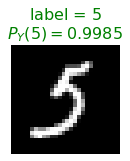

C:\Users\Or\AppData\Local\Temp/ipykernel_20020/122543935.py:20: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "transforms" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig('Output5.png', transforms=True, bbox_inches='tight')


In [142]:
nTest   = len(oTestSet)
idx     = np.random.randint(nTest)
# idx     = 8496
idx     = 3102

mXi, yi = oTestSet[idx]

with torch.no_grad():
    vLogits = oModel(mXi.unsqueeze(0).to(DEVICE)).squeeze().cpu()

vP = torch.softmax(vLogits, dim=0)
pi = vP[yi]

fig, ax = plt.subplots(figsize=(2, 2))
ax.matshow          (mXi[0], cmap='gray')
ax.xaxis.tick_bottom()
ax.axis             ('off')
ax.set_title        (f'label = ${yi}$\n' f'$P_Y({yi}) = {pi:5.4f}$', color='g', fontsize=16)
plt.show            ()
fig.savefig('Output5.png', transforms=True, bbox_inches='tight')

<IPython.core.display.Javascript object>


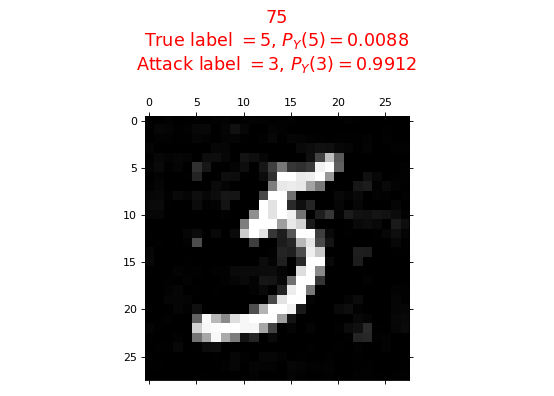

In [143]:
%matplotlib notebook

mXi, yi    = oTestSet[idx]
mOriginalX = mXi.clone()
yAttack    = 3
mXi        = mXi.to(DEVICE)

#-- No need to compute gradients of the model:
for param in oModel.parameters():
    param.requires_grad = False

lr      = 1e-2
fig, ax = plt.subplots(figsize=(7, 5))
for epoch in range(200):
    #-- We want to update mXi using gradient ascent:
    mXi               = mXi.detach()
    mXi.requires_grad = True
    
    #-- Model output:
    vLogits = oModel(mXi.unsqueeze(0))[0]
    vP      = torch.softmax(vLogits, dim=0)
    pTrue   = vP[yi]
    pAttack = vP[yAttack]
    
    #-- Compute the gradient w.r.t mXi
    loss    = vLogits[yAttack]
    loss.backward(retain_graph=False)
    
    # -- Add the gradient (or the sign of it)
#     mXi  = mXi + lr * torch.sign(mXi.grad)
    mXi  = mXi + lr * mXi.grad
    #-- Clamp the image:
    mXi  = torch.clamp(mXi, -1, 1)
    
    #-- Plot progress:
    color = 'g' if pTrue > pAttack else 'r'
    ax.cla          ()
    ax.matshow      (mXi.detach().cpu().squeeze(), cmap='gray')
    ax.set_title    (f'{epoch}\n'
                     f'True label $   = {yi}$, $    P_Y ({yi})      = {pTrue  :5.4f}$\n'
                     f'Attack label $ = {yAttack}$, $P_Y({yAttack}) = {pAttack:5.4f}$\n',
                     fontsize=16, color=color)
                     
    fig.canvas.draw ()
    plt.tight_layout()
    plt.pause       (1e-6)    
    
    if pAttack > 0.99:
        break

#### Plot the perturbation:

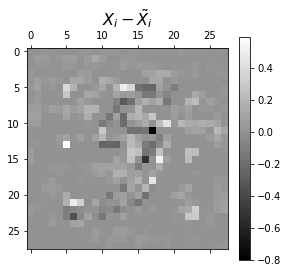

In [144]:
%matplotlib inline

mDiff = mXi.detach().cpu() - mOriginalX
plt.matshow  (mDiff[0], cmap='gray')
plt.title    (r'$X_i - \tilde{X}_i$', fontsize=16)
plt.colorbar(fraction=0.05);